<a href="https://colab.research.google.com/github/VirangParekh/Automated-EQ/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check for GPU
!nvidia-smi

Fri Apr 15 16:44:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading Libraries

In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=4baf75fac7e6cf2b25229cf4a1355166da90159f0929c832a5604cf8b95216e8
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import pandas as pd
from tensorflow.python.keras import regularizers

In [ ]:
vocab_size = 10000
embedding_dim = 64 #size of embeddig vector
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 5300 
emotion_size = 7

# Loading dataset

In [ ]:
df_isear =pd.read_csv('/content/drive/MyDrive/BE Project/Dataset/isear.csv',header=None)
# The isear.csv contains rows with value 'No response'
# We need to remove such rows
df_isear .drop(df_isear[df_isear[1] == '[ No response.]'].index, inplace = True)
df_isear

,0,1
0,joy,[ On days when I feel close to my partner and ...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...
...,...,...
7647,anger,Two years back someone invited me to be the tu...
7648,sadness,I had taken the responsibility to do something...
7649,disgust,I was at home and I heard a loud sound of spit...
7650,shame,I did not do the homework that the teacher had...


In [ ]:
isear_sentences = df_isear[1].tolist()
# labels = df[0].tolist()
# Hot Encodig
from sklearn.preprocessing import LabelBinarizer
isear_labels = LabelBinarizer().fit_transform(df_isear[0])
isear_labels

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

# Splitting data

In [ ]:
# training_sentences = sentences[0:training_size]
# testing_sentences = sentences[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

# testing_labels = tf.keras.utils.to_categorical(testing_labels, num_classes=7)

In [ ]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels \
        = train_test_split(isear_sentences , isear_labels, test_size=0.2, random_state=32)

# Tokenization 

In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

#saving the tokens in the variable
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Modelling



In [ ]:
import keras
from keras.layers import Activation, Dense, Dropout, GlobalMaxPooling1D
from keras_self_attention import SeqSelfAttention

model = Sequential()
model.add(Embedding(vocab_size, 40, input_length=100, embeddings_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=125,return_sequences=True) )) #,kernel_regularizer=regularizers.l2(0.1)
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add( GlobalMaxPooling1D() )
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax')) #,kernel_regularizer=regularizers.l2(0.1)


adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 40)           400000    
                                                                 
 dropout (Dropout)           (None, 100, 40)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 250)         166000    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 100, 250)         16065     
 Attention)                                                      
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                        

# Training

In [ ]:
num_epochs = 30
# hello there 
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/30
190/190 [==============================] - 22s 63ms/step - loss: 1.9900 - accuracy: 0.1474 - val_loss: 1.9924 - val_accuracy: 0.1782
Epoch 2/30
190/190 [==============================] - 11s 57ms/step - loss: 2.0384 - accuracy: 0.1876 - val_loss: 2.0883 - val_accuracy: 0.2330
Epoch 3/30
190/190 [==============================] - 11s 56ms/step - loss: 2.0432 - accuracy: 0.2728 - val_loss: 2.0384 - val_accuracy: 0.3300
Epoch 4/30
190/190 [==============================] - 11s 56ms/step - loss: 2.0963 - accuracy: 0.3776 - val_loss: 2.0957 - val_accuracy: 0.4515
Epoch 5/30
190/190 [==============================] - 11s 58ms/step - loss: 2.0484 - accuracy: 0.4665 - val_loss: 1.8963 - val_accuracy: 0.5373
Epoch 6/30
190/190 [==============================] - 11s 58ms/step - loss: 1.9801 - accuracy: 0.5125 - val_loss: 1.8712 - val_accuracy: 0.5710
Epoch 7/30
190/190 [==============================] - 11s 57ms/step - loss: 2.0085 - accuracy: 0.5285 - val_loss: 1.9457 - val_accuracy:

# Evaluating

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

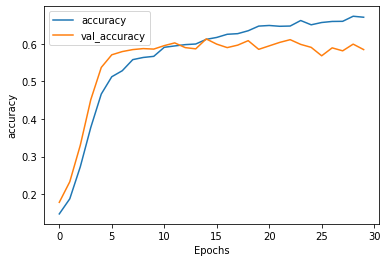

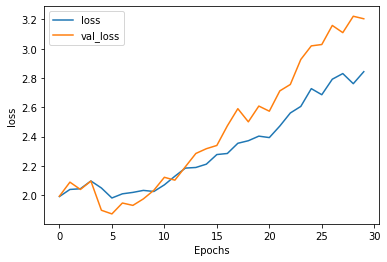

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Prediting

In [ ]:
sentence = ["i'm feeling very shameful","go to hell! "]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
result = model.predict(padded)
print(result)

[[0.0382015  0.07368571 0.02034079 0.26912925 0.0069626  0.07301121
  0.5186689 ]
 [0.07391163 0.38456216 0.24115056 0.07327541 0.02349668 0.05609264
  0.14751092]]


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit_transform(df_isear[0].to_numpy())

# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'],
      dtype=object)

In [ ]:
classes = tf.argmax(result, axis=1)
for emotion in classes:
  print(class_names[emotion])

shame
disgust


In [ ]:
labels = LabelBinarizer().fit_transform(df_isear[0])

In [ ]:
label_df = pd.DataFrame(labels)
label_df['emotion'] = df_isear[0]
label_df

# 0: anger
# 1: digust
# 2: fear
# 3: guilt
# 4: joy
# 5: sadness
# 6: shame

,0,1,2,3,4,5,6,emotion
0,0,0,0,0,1,0,0,joy
1,0,0,1,0,0,0,0,fear
2,1,0,0,0,0,0,0,anger
3,0,0,0,0,0,1,0,sadness
4,0,1,0,0,0,0,0,disgust
...,...,...,...,...,...,...,...,...
7570,1,0,0,0,0,0,0,anger
7571,0,0,0,0,0,1,0,sadness
7572,0,1,0,0,0,0,0,disgust
7573,0,0,0,0,0,0,1,shame


Text(0.5, 1.0, "i'm feeling very shameful")

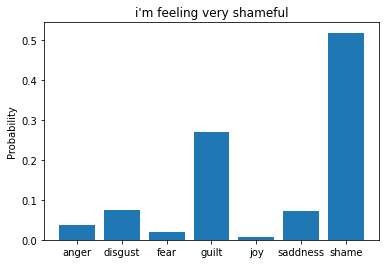

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

names = ['anger','disgust','fear','guilt','joy','saddness', 'shame']

plt.bar(names, result[0])
plt.xticks(names)
plt.xlabel('')
plt.ylabel('Probability')
plt.title(sentence[0])

Text(0.5, 1.0, 'go to hell! ')

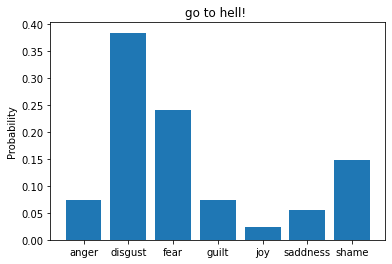

In [ ]:
plt.bar(names, result[1])
plt.xticks(names)
plt.xlabel('')
plt.ylabel('Probability')
plt.title(sentence[1])

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
model.save('my_model.h5')

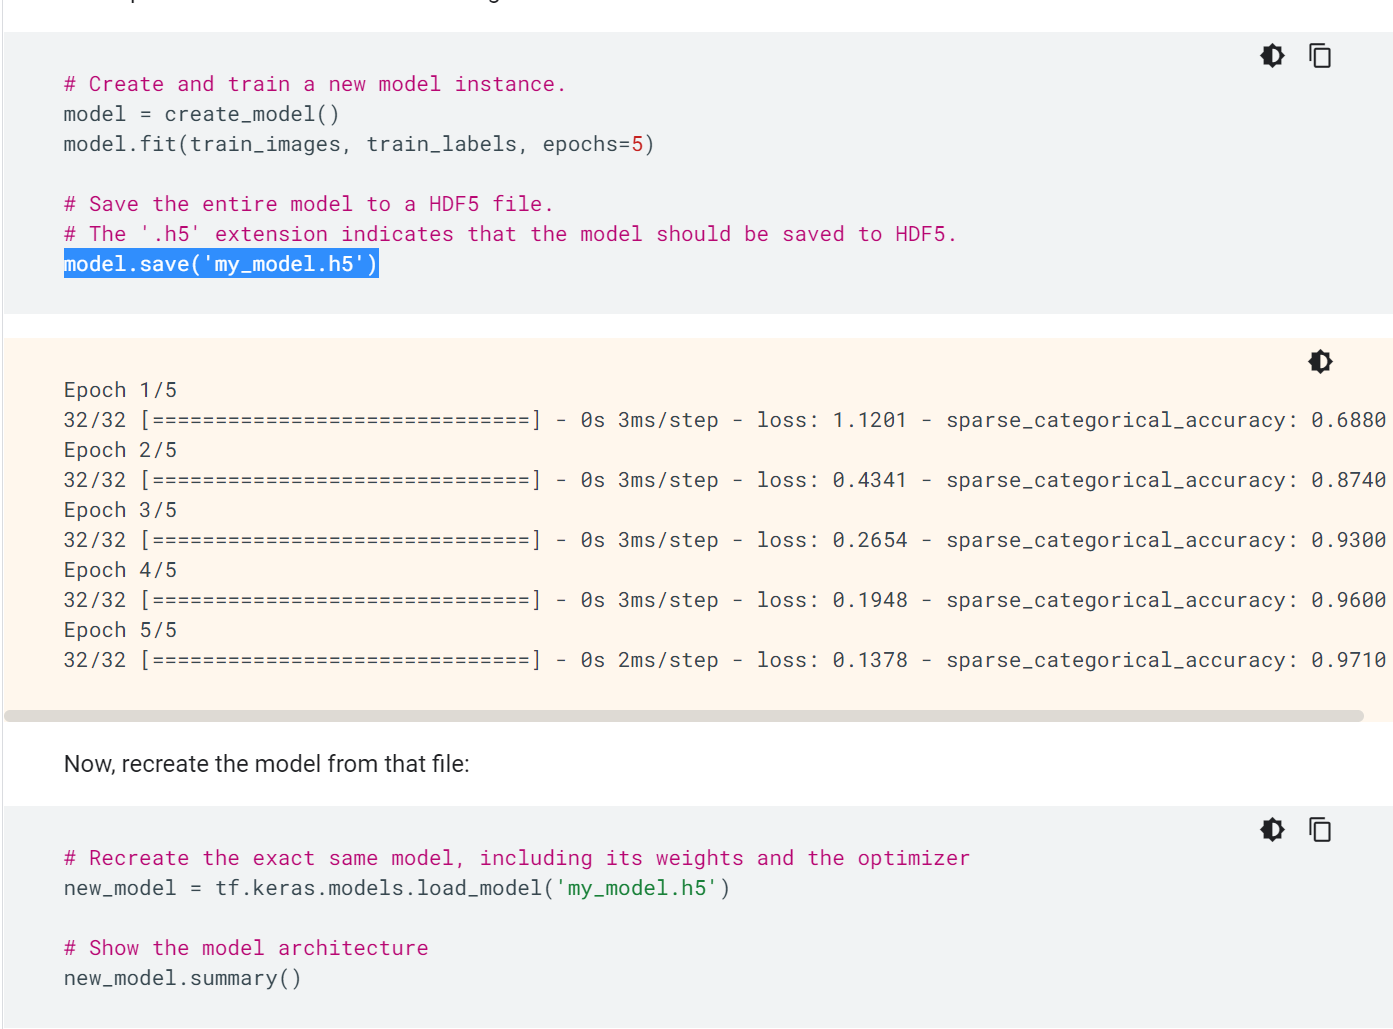